In [1]:
# same imports as above but saves me time from scrolling up when restarting the notebook.
from dask.distributed import Client, LocalCluster, Nanny, SchedulerPlugin, WorkerPlugin, Future, secede, rejoin, get_worker
from dask.distributed import print as dprint
from dask.highlevelgraph import HighLevelGraph
from dask.distributed import Variable, Queue, Event, get_client, worker_client
from dask.diagnostics import ProgressBar, Profiler
import numpy as np
import dask
import dask.array as da
import dask.dataframe as dd
import graphviz
import logging
import itertools
import time
import zmq
import yaml
import subprocess
import os

In [2]:
# Define the commands
def worker_command(name: str):
    return [
    "dask", "worker",
    "--scheduler-file", "scheduler.json",
    "--local-directory", "./workers",
    "--nthreads", "1",
    "--name", name,
    "--resources", "mem=1e6",
    "--resources", "p=1"
]

scheduler_command = [
    "dask", "scheduler",
    "--scheduler-file", "scheduler.json"
]

# Function to run a process in the background
def run_in_background(command):
    subprocess.Popen(
        command,
        stdout=subprocess.DEVNULL,  # Discard standard output
        stderr=subprocess.DEVNULL,  # Discard standard error
        preexec_fn=os.setpgrp       # Detach the process from the current session
    )

# Start the scheduler and worker in the background
run_in_background(scheduler_command)

time.sleep(3)

with open("scheduler.json", "r") as f:
    cfg = yaml.safe_load(f)

addr = cfg["address"]
print(f"Scheduler connected at {addr}")

client = Client(addr)

run_in_background(worker_command("worker0"))
run_in_background(worker_command("worker1"))


print("Scheduler and workers started in the background.")

Scheduler connected at tcp://129.88.54.109:8786
Scheduler and workers started in the background.


# Without time dependencies

Create the dask array without the time dependencies "trick". Conceptually, it's ok, but we have the issue that there is no ordering as to which tasks are scheduled first. So the task for the last timestep might go first and pull from the Queue which has the future for the first timestep. Therefore the array ends up shuffled.

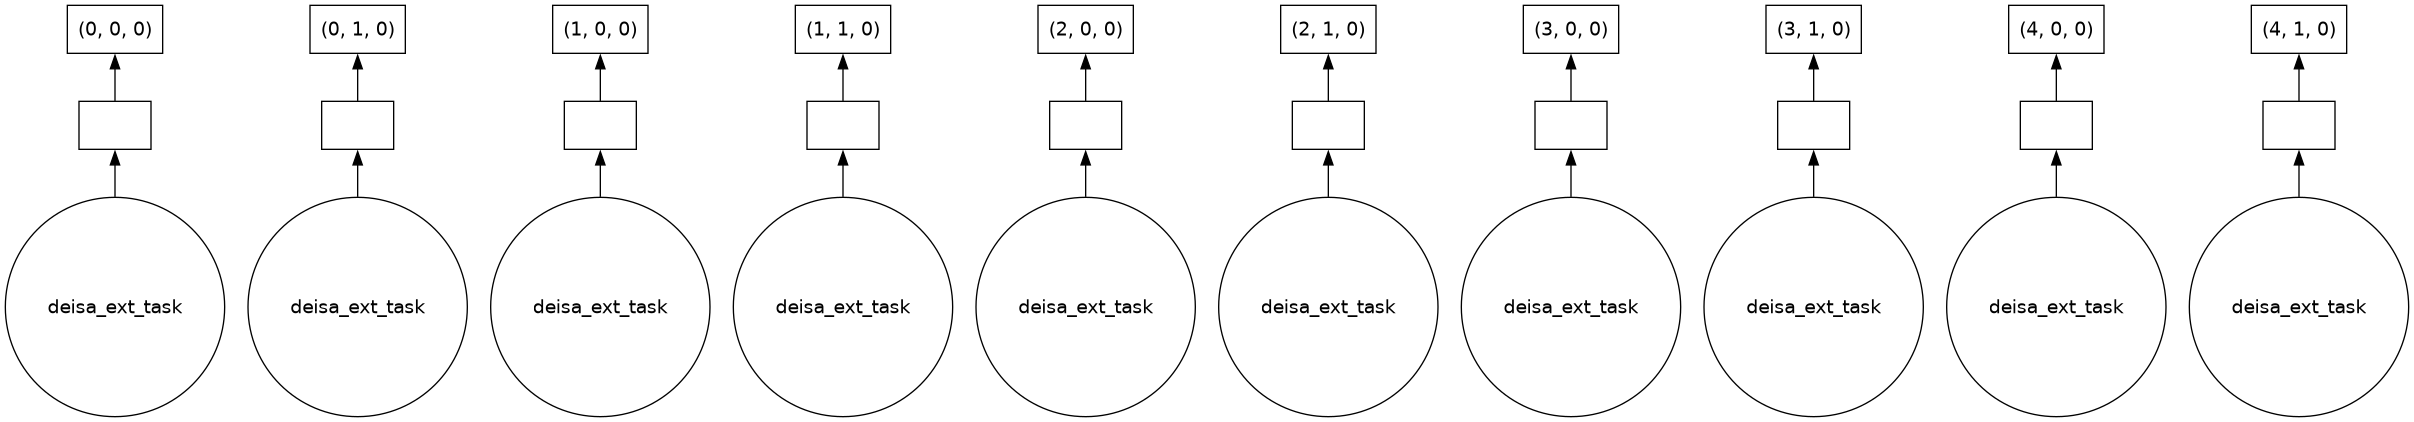

In [3]:
def deisa_array(name, shape, chunksize, dtype):
    # not using queues but just random numpy array to show the concept
    @dask.delayed
    def deisa_ext_task(chunksize: list[int]):
        return np.random.rand(*chunksize)
        
    chunks_in_each_dim = [shape[i] // chunksize[i] for i in range(len(shape))]
    chunks = tuple(
                [(chunksize[i],) * chunks_in_each_dim[i] for i in range(len(shape))]
            )
    chunk_coords = list(itertools.product(*[range(i) for i in chunks_in_each_dim]))
    custom_gt = {}
    deps = []
    for coord in chunk_coords:
        # tasks with bigger time steps will wait longer. This simulates the idea later time steps will be produced later.
        value = deisa_ext_task(chunksize = chunksize)
        deps.append(value)
        custom_gt[(name, *coord)] = value.key        
    dsk = HighLevelGraph.from_collections(name, custom_gt, dependencies = deps)
    custom_gt = da.Array(dsk, name, chunks, dtype)
    return custom_gt
custom_gt = deisa_array(name = "ex-gt", shape = [5,10,20],  chunksize = [1,5,20], dtype = float )
custom_gt.visualize()

In [4]:
custom_gt[0,0,:].compute()

array([2.41281027e-02, 4.66959308e-01, 8.17631773e-01, 7.62430526e-01,
       4.19626739e-01, 9.54283301e-01, 2.67469070e-01, 7.39938551e-01,
       4.77958742e-04, 7.37695181e-01, 9.19876825e-01, 9.19565128e-01,
       4.00943025e-01, 1.70019390e-01, 9.70410957e-01, 3.00492227e-01,
       5.68257748e-01, 4.71994456e-01, 5.87980613e-01, 6.00347737e-01])

# With time dependencies and using Queues

The idea is that each MPI rank creates a Queue (a global variable accessible by all Dask clients) where it will put the futures of the scatter operation. Since each MPI rank deals with the same part of the grid, we have a one to one mapping between "task-id" (time invariant) and "MPI ranks". For example, task (0,0) will always come from rank0 and so on. Then, each external task is essentially a "pull" from the Queue. We just have to make sure that tasks pull in order. We do this by introducing a fake time dependency.

coord=(0, 0, 0) task_id=(0, 0) rank='rank0'
coord=(0, 1, 0) task_id=(1, 0) rank='rank1'
coord=(1, 0, 0) task_id=(0, 0) rank='rank0'
coord=(1, 1, 0) task_id=(1, 0) rank='rank1'
coord=(2, 0, 0) task_id=(0, 0) rank='rank0'
coord=(2, 1, 0) task_id=(1, 0) rank='rank1'
coord=(3, 0, 0) task_id=(0, 0) rank='rank0'
coord=(3, 1, 0) task_id=(1, 0) rank='rank1'
coord=(4, 0, 0) task_id=(0, 0) rank='rank0'
coord=(4, 1, 0) task_id=(1, 0) rank='rank1'


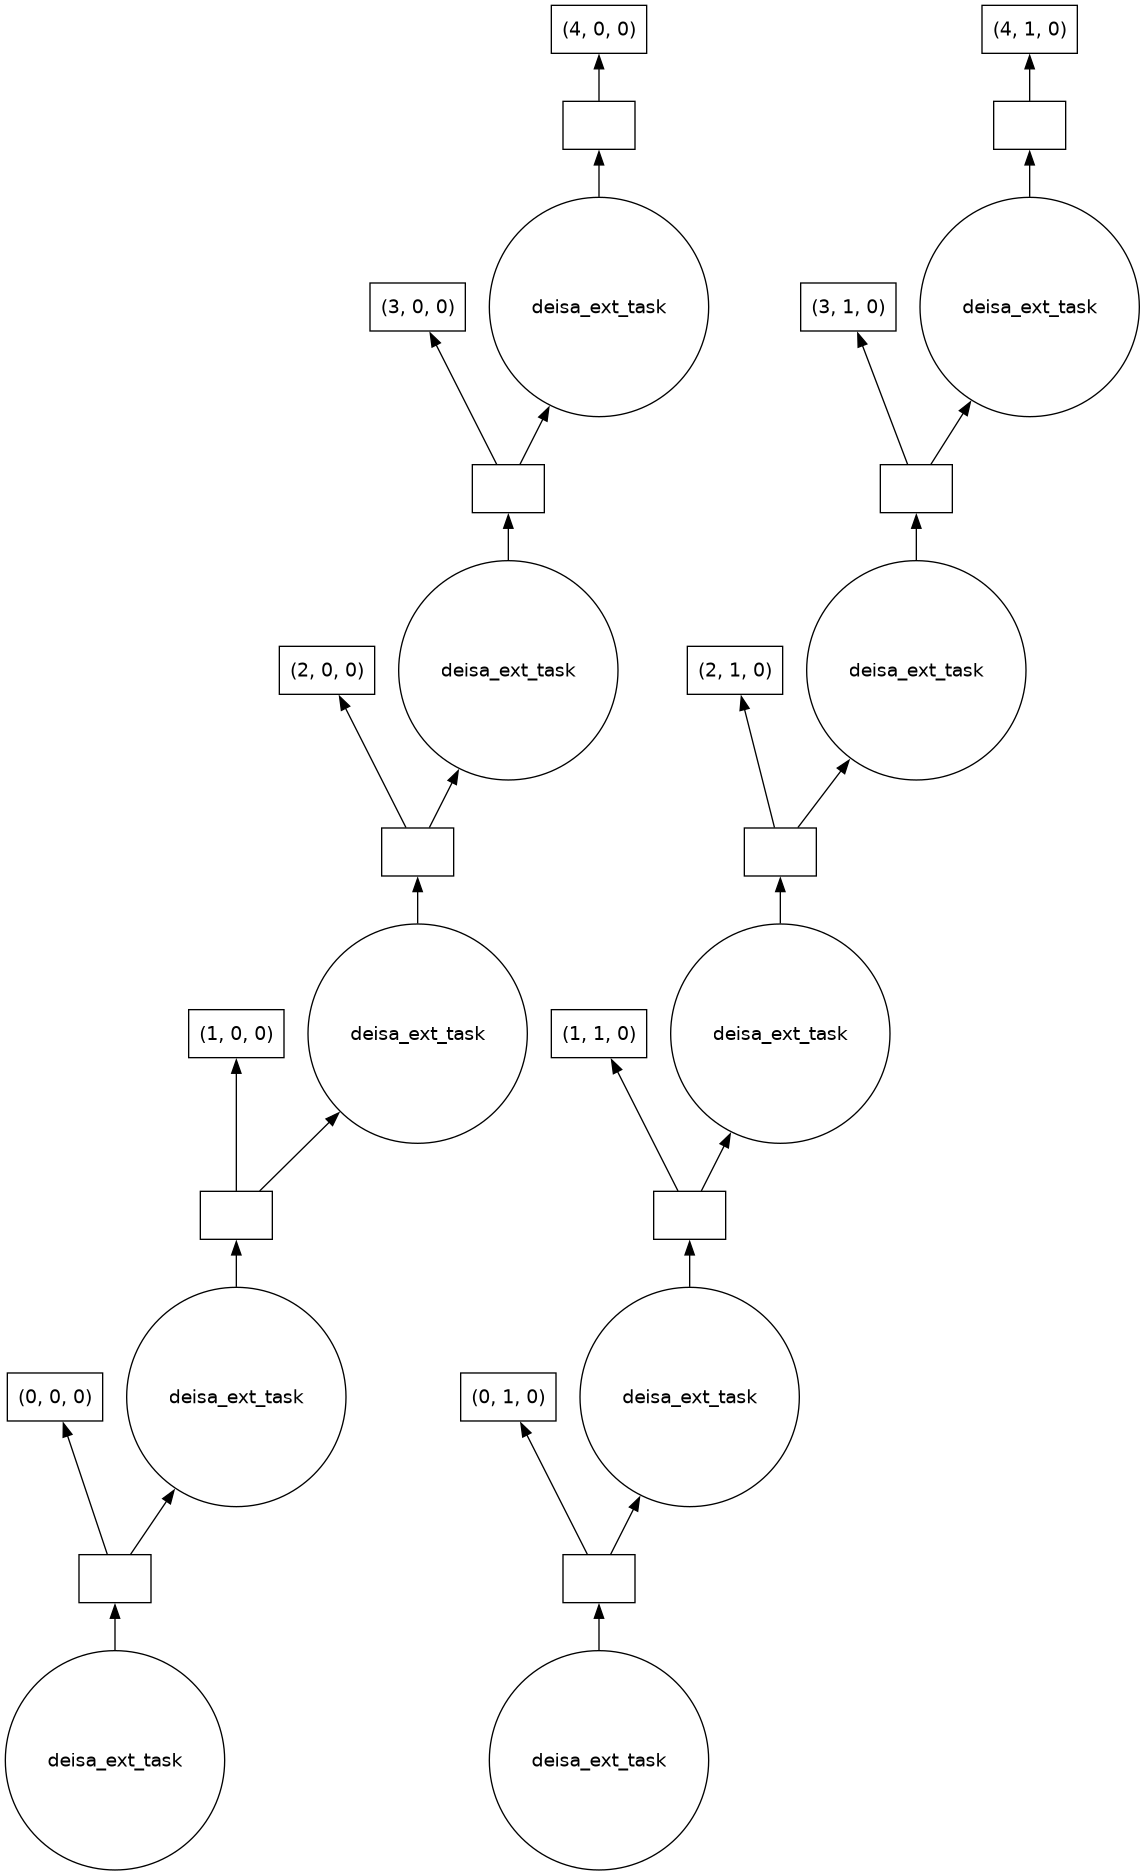

In [5]:
# Each rank will always keep working on the same task. It is time independent. So we just need to create the 
# map once.
task_to_rank = {
    (0,0): "rank0",
    (1,0): "rank1",
}
def deisa_array(name, shape, chunksize, dtype):
    @dask.delayed
    def deisa_ext_task(pull_from, depends_on = None):
        with worker_client() as c:
            f = Queue(pull_from).get()
        return f.result()
        
    chunks_in_each_dim = [shape[i] // chunksize[i] for i in range(len(shape))]
    chunks = tuple(
                [(chunksize[i],) * chunks_in_each_dim[i] for i in range(len(shape))]
            )
    chunk_coords = list(itertools.product(*[range(i) for i in chunks_in_each_dim]))
    # chunk coords identify the task (except for the time dim)
    custom_gt = {}
    deps = []
    for coord in chunk_coords:
        # remove time dim
        task_id = coord[1:]
        rank = task_to_rank[task_id]
        print(f"{coord=} {task_id=} {rank=}")
        # timestep0 has no dependency since it has to be scheduled first
        if coord[0]==0:
            value = deisa_ext_task(pull_from = rank)
            deps.append(value)
        # all other timesteps depend on the previous one
        else:
            value = deisa_ext_task(pull_from = rank, depends_on = custom_gt[(name, coord[0]-1, *coord[1:])])
            deps.append(value)
       
        custom_gt[(name, *coord)] = value.key        
    dsk = HighLevelGraph.from_collections(name, custom_gt, dependencies = deps)
    custom_gt = da.Array(dsk, name, chunks, dtype)
    return custom_gt
custom_gt = deisa_array(name = "ex-gt", shape = [5,10,20],  chunksize = [1,5,20], dtype = float)
custom_gt.visualize()

In [6]:
def Derivee(F, dx):
    """
    First Derivative
    Input: F = function to be derived
           dx = step of the variable for derivative
    Output: dFdx = first derivative of F
    """
    c0 = 2.0 / 3.0
    dFdx = c0 / dx * (F[3:-1] - F[1:-3] - (F[4:] - F[:-4]) / 8.0)
    return dFdx

In [7]:
with dask.config.set(array_optimize=None):
    withdask = Derivee(custom_gt, 1).mean()
    d_withdask = withdask.compute()
print(d_withdask)    

-0.015356927038894718
